In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

c:\Users\srika\anaconda3\envs\king\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def set_seed(no):
    torch.manual_seed(no)
    random.seed(no)
    np.random.seed(no)
    os.environ['PYTHONHASHSEED'] = str()
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(100)

In [3]:
print(torch.__version__)

2.4.0+cu118


In [6]:
cd "C:\Users\srika\Downloads"

C:\Users\srika\Downloads


In [7]:
ls

 Volume in drive C is Windows-SSD
 Volume Serial Number is C420-418F

 Directory of C:\Users\srika\Downloads

27-08-2023  23:04           593,261 # LAB 4  - Vinayaka R Srinivas - 20MIA1041.html
08-04-2022  21:47           240,968 #BrandSeries 01.apple.twbx
16-04-2021  06:25    <DIR>          (Footage)
25-10-2024  23:04    <DIR>          .
24-10-2024  04:57    <DIR>          ..
16-10-2021  02:02            96,147 .ci.yaml
21-09-2024  14:56    <DIR>          .ipynb_checkpoints
29-06-2024  22:06           186,186 .RData
29-06-2024  22:06            12,024 .Rhistory
12-09-2024  18:01               184 .wget-hsts
28-02-2023  15:38         4,438,775 @hla_vitc (1).png
28-02-2023  15:15         4,117,782 @hla_vitc.png
28-06-2022  22:30            22,896 [Downloader.la]-62bb33bb8124b.jpg
07-08-2022  11:50            59,731 [Downloader.la]-62ef599230765.jpg
13-09-2022  16:59            74,896 [Downloader.la]-6320696c9719f.jpg
18-04-2022  18:53            70,710 [GetPaidStock.com]-625d664e07c8b.j

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(280),
        transforms.RandomResizedCrop(280),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(280),
        transforms.CenterCrop(280),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'Dataset-challnge/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
image_datasets['train'].classes

['Angioectasia',
 'Bleeding',
 'Erosion',
 'Erythema',
 'Foreign Body',
 'Lymphangiectasia',
 'Normal',
 'Polyp',
 'Ulcer',
 'Worms']

In [9]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x2150122f0a0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x2150122a5e0>}

Model


In [10]:
# load dino model
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

Using cache found in C:\Users\srika/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\srika/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\srika/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\srika/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [11]:
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = dinov2_vits14
        self.classifier = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
    
    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        return x

In [12]:
import torch.optim as optim

model = DinoVisionTransformerClassifier()


criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.000001)

In [13]:
len(dataloaders["train"])

588

In [14]:
model = model.to(device)

Train

In [16]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloaders["train"], 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 1.339
[1,   100] loss: 0.958
[1,   150] loss: 0.833
[1,   200] loss: 0.773
[1,   250] loss: 0.769
[1,   300] loss: 0.775
[1,   350] loss: 0.716
[1,   400] loss: 0.707
[1,   450] loss: 0.660
[1,   500] loss: 0.650
[1,   550] loss: 0.601
[2,    50] loss: 0.564
[2,   100] loss: 0.577
[2,   150] loss: 0.575
[2,   200] loss: 0.534
[2,   250] loss: 0.560
[2,   300] loss: 0.523
[2,   350] loss: 0.499
[2,   400] loss: 0.489
[2,   450] loss: 0.508
[2,   500] loss: 0.495
[2,   550] loss: 0.477
[3,    50] loss: 0.490
[3,   100] loss: 0.460
[3,   150] loss: 0.435
[3,   200] loss: 0.437
[3,   250] loss: 0.429
[3,   300] loss: 0.471
[3,   350] loss: 0.452
[3,   400] loss: 0.449
[3,   450] loss: 0.432
[3,   500] loss: 0.407
[3,   550] loss: 0.437
[4,    50] loss: 0.399
[4,   100] loss: 0.393
[4,   150] loss: 0.422
[4,   200] loss: 0.406
[4,   250] loss: 0.410
[4,   300] loss: 0.385
[4,   350] loss: 0.396
[4,   400] loss: 0.388
[4,   450] loss: 0.401
[4,   500] loss: 0.383
[4,   550] 

Testing

In [17]:
# Save the model
model_save_path = r"C:\Users\srika\OneDrive\Desktop\Deskop\New folder\dino_vit_classifier_capsule.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to C:\Users\srika\OneDrive\Desktop\Deskop\New folder\dino_vit_classifier_capsule.pth


Gradcam not possible as conv layer is not extrating much features (or) shall we try on the first conv layer in arch

In [18]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders["test"]:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to("cpu") == labels).sum().item()

print(f'Accuracy of the network on the {len(dataloaders["test"])*6} test images: {100 * correct // total} %')

Accuracy of the network on the 1518 test images: 93 %


In [23]:
import torch
import pandas as pd
import numpy as np
from torchvision import transforms
from PIL import Image
import os

# Load the model (same as before)
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = dinov2_vits14
        self.classifier = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Linear(256, 10)  # Assuming 10 classes
        )
    
    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        return x

# Instantiate and load the saved weights
model = DinoVisionTransformerClassifier()
model_save_path = r"C:\Users\srika\OneDrive\Desktop\Deskop\New folder\dino_vit_classifier_capsule.pth"
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set to evaluation mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the image transformations
data_transforms = transforms.Compose([
    transforms.Resize(280),
    transforms.CenterCrop(280),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load and process the test images
test_image_folder = r'C:\Users\srika\Downloads\Testing set\Testing set\Images'  # Set to the folder containing test images
image_paths = [os.path.join(test_image_folder, img) for img in os.listdir(test_image_folder) if img.endswith('.jpg')]

# Prediction process
class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 
                 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
all_image_paths = []
all_predictions = []

with torch.no_grad():
    for img_path in image_paths:
        image = Image.open(img_path).convert('RGB')
        input_tensor = data_transforms(image).unsqueeze(0).to(device)
        
        outputs = model(input_tensor)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
        predicted_class = np.argmax(probabilities, axis=1)

        all_image_paths.append(os.path.basename(img_path))
        all_predictions.append(probabilities[0])

# Save predictions in the desired format
def save_predictions_to_csv(image_paths, predictions, output_path):
    df_prob = pd.DataFrame(predictions, columns=class_columns)
    df_prob.insert(0, 'image_path', image_paths)
    
    y_pred_classes = np.argmax(predictions, axis=1)
    predicted_class_names = [class_columns[i] for i in y_pred_classes]
    df_prob['predicted_class'] = predicted_class_names
    
    df_prob.to_csv(output_path, index=False)

# Save predictions to CSV
output_path = 'submission_capsule.csv'
save_predictions_to_csv(all_image_paths, np.array(all_predictions), output_path)

print(f"Predictions saved to {output_path}")


C:\Users\srika\AppData\Local\Temp\ipykernel_4424\2246011448.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Predictions saved to submission_capsule.csv


In [27]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, recall_score, f1_score, balanced_accuracy_score
import json

# Function to save predictions to Excel
def save_predictions_to_excel(image_paths, y_pred, output_path):
    class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
    y_pred_classes = np.argmax(y_pred, axis=1)
    predicted_class_names = [class_columns[i] for i in y_pred_classes]
    df_prob = pd.DataFrame(y_pred, columns=class_columns)
    df_prob.insert(0, 'image_path', image_paths)
    df_class = pd.DataFrame({'image_path': image_paths, 'predicted_class': predicted_class_names})
    df_merged = pd.merge(df_prob, df_class, on='image_path')
    df_merged.to_excel(output_path, index=False)
    
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, f1_score, balanced_accuracy_score
import json

def calculate_specificity(y_true_class, y_pred_class):
    tn = np.sum((y_true_class == 0) & (y_pred_class == 0))
    fp = np.sum((y_true_class == 0) & (y_pred_class == 1))
    specificity = tn / (tn + fp + 1e-10)  # Avoid division by zero
    return specificity

def calculate_sensitivity(y_true_class, y_pred_class):
    tp = np.sum((y_true_class == 1) & (y_pred_class == 1))
    fn = np.sum((y_true_class == 1) & (y_pred_class == 0))
    sensitivity = tp / (tp + fn + 1e-10)  # Avoid division by zero
    return sensitivity

def generate_metrics_report(y_true, y_pred):
    class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
    metrics_report = {}

    # If y_pred contains probabilities, convert to class labels using argmax
    if y_pred.ndim > 1:
        y_pred_classes = np.argmax(y_pred, axis=1)
    else:
        y_pred_classes = y_pred  # Already class labels
    
    y_true_classes = y_true  # Assuming these are class labels

    # Generate classification report
    class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_columns, output_dict=True, zero_division=0)

    # Initialize metric holders
    auc_roc_scores = {}
    average_precision_scores = {}
    sensitivity_scores = {}
    specificity_scores = {}
    f1_scores = {}

    # Calculate per-class metrics
    for i, class_name in enumerate(class_columns):
        y_true_class = (y_true_classes == i).astype(int)
        y_pred_class = (y_pred_classes == i).astype(int)

        # AUC-ROC
        if y_pred.ndim > 1:
            auc_roc_scores[class_name] = roc_auc_score(y_true_class, y_pred[:, i])
        else:
            auc_roc_scores[class_name] = roc_auc_score(y_true_class, y_pred_class)

        # Average Precision
        average_precision_scores[class_name] = average_precision_score(y_true_class, y_pred_class)

        # Specificity
        specificity_scores[class_name] = calculate_specificity(y_true_class, y_pred_class)

        # Sensitivity (Recall)
        sensitivity_scores[class_name] = calculate_sensitivity(y_true_class, y_pred_class)

        # F1 Score
        f1_scores[class_name] = f1_score(y_true_class, y_pred_class)

    # Mean values of each metric
    mean_auc_roc = np.mean(list(auc_roc_scores.values()))
    mean_specificity = np.mean(list(specificity_scores.values()))
    mean_average_precision = np.mean(list(average_precision_scores.values()))
    mean_sensitivity = np.mean(list(sensitivity_scores.values()))
    mean_f1_score = np.mean(list(f1_scores.values()))

    # Balanced accuracy
    balanced_accuracy_scores = balanced_accuracy_score(y_true_classes, y_pred_classes)

    # Update the metrics report
    metrics_report.update(class_report)
    metrics_report['auc_roc_scores'] = auc_roc_scores
    metrics_report['specificity_scores'] = specificity_scores
    metrics_report['average_precision_scores'] = average_precision_scores
    metrics_report['sensitivity_scores'] = sensitivity_scores
    metrics_report['f1_scores'] = f1_scores
    metrics_report['mean_auc'] = mean_auc_roc
    metrics_report['mean_specificity'] = mean_specificity
    metrics_report['mean_average_precision'] = mean_average_precision
    metrics_report['mean_sensitivity'] = mean_sensitivity
    metrics_report['mean_f1_score'] = mean_f1_score
    metrics_report['balanced_accuracy'] = balanced_accuracy_scores

    metrics_report_json = json.dumps(metrics_report, indent=4)
    return metrics_report_json


# Set to evaluation mode
model.eval()

# Prepare for test set evaluation
all_image_paths = []  # Store image paths
all_predictions = []  # Store predictions
all_labels = []  # Store true labels

correct = 0
total = 0

with torch.no_grad():
    for data in dataloaders["test"]:  # Assuming 'dataloaders["test"]' is defined
        images, labels = data
        all_labels.append(labels.cpu().numpy())  # Store true labels
        
        outputs = model(images.to(device))
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
        
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.append(probabilities)  # Store probabilities
        
        total += labels.size(0)
        correct += (predicted.to("cpu") == labels).sum().item()

# Flatten lists of predictions and labels
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Calculate Accuracy
accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')

# Generate the metrics report
metrics_report = generate_metrics_report(all_labels, all_predictions)
print(metrics_report)

# Save predictions to Excel
output_excel_path = "predictions_output.xlsx"
image_paths = [f"Image_{i}" for i in range(len(all_predictions))]  # Example image names, replace with actual if needed
save_predictions_to_excel(image_paths, all_predictions, output_excel_path)
print(f"Predictions saved to {output_excel_path}")


Accuracy on the test set: 93.28%
{
    "Angioectasia": {
        "precision": 0.8326271186440678,
        "recall": 0.7907444668008048,
        "f1-score": 0.8111455108359134,
        "support": 497.0
    },
    "Bleeding": {
        "precision": 0.8707865168539326,
        "recall": 0.8635097493036211,
        "f1-score": 0.8671328671328671,
        "support": 359.0
    },
    "Erosion": {
        "precision": 0.8015952143569293,
        "recall": 0.6961038961038961,
        "f1-score": 0.7451343836886005,
        "support": 1155.0
    },
    "Erythema": {
        "precision": 0.6196581196581197,
        "recall": 0.4882154882154882,
        "f1-score": 0.5461393596986818,
        "support": 297.0
    },
    "Foreign Body": {
        "precision": 0.9213836477987422,
        "recall": 0.861764705882353,
        "f1-score": 0.8905775075987842,
        "support": 340.0
    },
    "Lymphangiectasia": {
        "precision": 0.9088050314465409,
        "recall": 0.8425655976676385,
        

Classification Report:
                   precision    recall  f1-score   support

    Angioectasia       0.83      0.79      0.81       497
        Bleeding       0.87      0.86      0.87       359
         Erosion       0.80      0.70      0.75      1155
        Erythema       0.62      0.49      0.55       297
    Foreign Body       0.92      0.86      0.89       340
Lymphangiectasia       0.91      0.84      0.87       343
          Normal       0.97      0.99      0.98     12287
           Polyp       0.66      0.71      0.69       500
           Ulcer       0.95      0.87      0.91       286
           Worms       0.98      0.74      0.84        68

        accuracy                           0.93     16132
       macro avg       0.85      0.78      0.81     16132
    weighted avg       0.93      0.93      0.93     16132

Normalized Confusion Matrix
[[7.90744467e-01 1.20724346e-02 6.63983903e-02 1.20724346e-02
  0.00000000e+00 2.01207243e-03 9.25553320e-02 2.41448692e-02
  0.00000

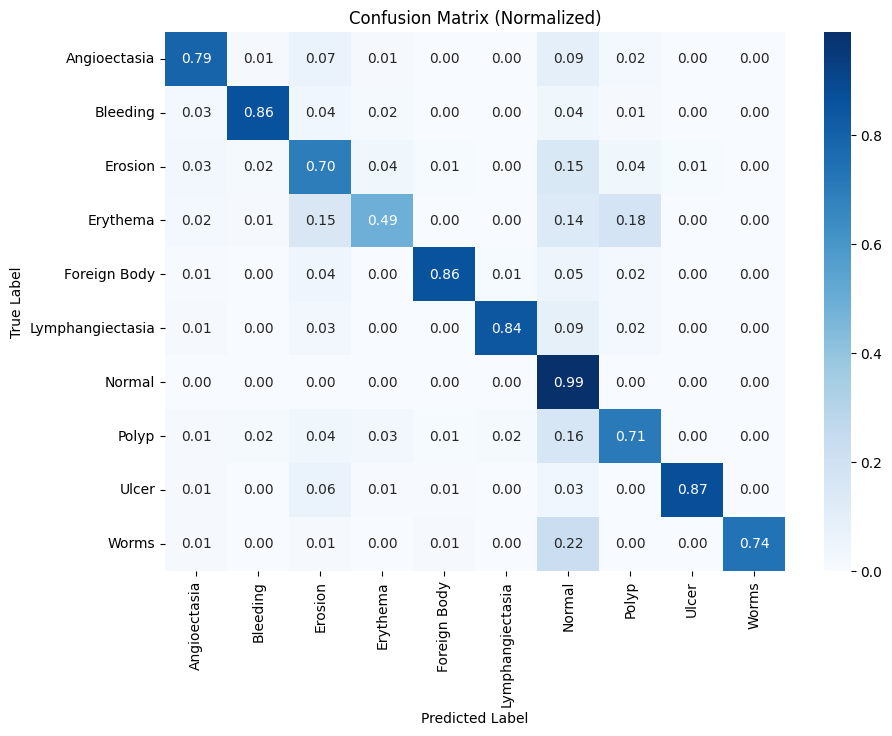

In [30]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, class_names, normalize=False):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix (Without Normalization)")
    
    print(cm)
    
    # Plotting the confusion matrix using seaborn's heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix" + (" (Normalized)" if normalize else ""))
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

def generate_classification_report_and_confusion_matrix(y_true, y_pred_proba, class_columns, normalize_cm=False):
    # Convert continuous predictions to class labels using argmax (for multiclass classification)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Classification report
    class_report = classification_report(y_true, y_pred, target_names=class_columns, zero_division=0)
    print("Classification Report:\n", class_report)

    # Confusion Matrix (can be normalized)
    plot_confusion_matrix(y_true, y_pred, class_columns, normalize=normalize_cm)

# Example usage:
# Assuming `all_labels` contains the true labels and `all_predictions` contains the predicted probabilities
class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']

# Call the function with normalization
generate_classification_report_and_confusion_matrix(all_labels, all_predictions, class_columns, normalize_cm=True)
